# Download and process the Bay Area's street network
### for BPR coefficients calculation

In [1]:
import time
import os, zipfile, requests, pandas as pd, geopandas as gpd, osmnx as ox, networkx as nx

ox.config(use_cache=True, log_console=True)
print('ox {}\nnx {}'.format(ox.__version__, nx.__version__))
start_time = time.time()

ox 0.7.3.dev
nx 2.2rc1.dev_20180226172658


In [2]:
# point to the shapefile for counties
counties_shapefile_url = 'http://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_county_500k.zip'

# identify bay area counties by fips code
bayarea = {'Alameda':'001',
           'Contra Costa':'013',
           'Marin':'041',
           'Napa':'055',
           'San Francisco':'075',
           'San Mateo':'081',
           'Santa Clara':'085',
           'Solano':'095',
           'Sonoma':'097'}

## Download and extract the counties shapefile if it doesn't already exist, then load it

To use OSMnx, we need a polygon of the Bay Area's nine counties. So, we'll download a shapefile from the census, extract our counties, and take the union to form a polygon. Also, project the polygon so we can calculate its area for density stats.

In [3]:
counties_shapefile_zip = counties_shapefile_url[counties_shapefile_url.rfind('/') + 1 :]
counties_shapefile_dir = counties_shapefile_zip[: counties_shapefile_zip.rfind('.zip')]
if not os.path.exists(counties_shapefile_dir):
    response = requests.get(counties_shapefile_url)
    with open(counties_shapefile_zip, 'wb') as f:
        f.write(response.content)
        with zipfile.ZipFile(counties_shapefile_zip, 'r') as zip_file:
            zip_file.extractall(counties_shapefile_dir)
    os.remove(counties_shapefile_zip)

In [4]:
counties = gpd.read_file(counties_shapefile_dir)
len(counties)

3233

In [5]:
# retain only those tracts that are in the bay area counties
mask = (counties['STATEFP'] == '06') & (counties['COUNTYFP'].isin(bayarea.values()))
gdf_bay = counties[mask]
len(gdf_bay)

9

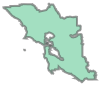

In [6]:
bayarea_polygon = gdf_bay.unary_union
bayarea_polygon

In [7]:
# get the convex hull, otherwise we'll cut out bridges over the bay
bayarea_polygon = bayarea_polygon.convex_hull
bayarea_polygon_proj, crs = ox.project_geometry(bayarea_polygon)

## Download the street network

Now we've got our polygon. Use OSMnx to download the street network (drivable roads).

In [8]:
# do not simplify yet, we'll strip out unwanted local streets first
G = ox.graph_from_polygon(bayarea_polygon, network_type='drive', simplify=False)

In [9]:
print(len(G.nodes()))
print(len(G.edges()))

1189833
2276768


## Filter the network to retain only tertiary streets and up

Including "unclassified" and "road" types as they often serve as null values. (Maybe we don't need unclassified though, as it's supposed to define roads in the hierarchy one level below tertiary.)

In [10]:
# identify all the edge types we want to retain
types = ['motorway', 'motorway_link', 'trunk', 'trunk_link', 
         'primary', 'primary_link', 'secondary', 'secondary_link',
         'tertiary', 'tertiary_link', 'unclassified', 'road']

minor_streets = [(u, v, k) for u, v, k, d in G.edges(keys=True, data=True) if d['highway'] not in types]

In [11]:
# remove minor streets and retain only the largest connected component subgraph
G_ter = G.copy()
G_ter.remove_edges_from(minor_streets)
G_ter = ox.remove_isolated_nodes(G_ter)
G_ter_connected = ox.get_largest_component(G_ter, strongly=False)

In [12]:
# then simplify the graph now that we have only the edge types we want
G_ter_simp = ox.simplify_graph(G_ter_connected, strict=True)

In [13]:
print(len(G_ter_simp.nodes()))
print(len(G_ter_simp.edges()))

31535
66112


## Create a unique ID for each edge

By default, we're using osmid as ID, but these can hold multiple values due to the topology simplification. So let's create a new unique for each edge.

In [14]:
i = 0
for u, v, k, d in G_ter_simp.edges(data=True, keys=True):
    d['uniqueid'] = i
    i += 1

In [15]:
# graph creation is all done, show elapsed time
elapsed_time = time.time() - start_time
elapsed_time

464.8574786186218

## Finally: calculate summary stats, save to disk

In [16]:
# see some basic network stats
pd.Series(ox.basic_stats(G_ter_simp, area=bayarea_polygon_proj.area))

circuity_avg                                                               1.11214
clean_intersection_count                                                      None
clean_intersection_density_km                                                 None
edge_density_km                                                            1127.35
edge_length_avg                                                            467.904
edge_length_total                                                      3.09341e+07
intersection_count                                                           28954
intersection_density_km                                                    1.05518
k_avg                                                                      4.19293
m                                                                            66112
n                                                                            31535
node_density_km                                                            1.14924
self

In [17]:
# save simplified tertiary+ edges to disk as csv
edges = ox.graph_to_gdfs(G_ter_simp, nodes=False, fill_edge_geometry=False)
edges.to_csv('data/bay_area_edges.csv', index=False, encoding='utf-8')

In [18]:
# save as graphml for re-using later
ox.save_graphml(G_ter_simp, filename='bayarea_tertiary_simplified.graphml', folder='data')

In [19]:
# save as shapefile for GIS
ox.save_graph_shapefile(G_ter_simp, filename='bayarea_tertiary_simplified')

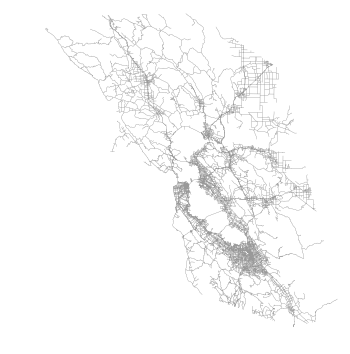

In [20]:
# visualize the network
fig, ax = ox.plot_graph(G_ter_simp, node_size=0, edge_linewidth=0.2)